## Dual Comb Model Testing

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
numberOfCombs=200
noiseOfPulse=0.7


params = [{'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': noiseOfPulse, 'jitter': 0.00, 'drift': 0.000, 'n_0': 000.0, 'alpha_0': 0.0},
          ]
          #{'rep_rate': 1.0e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': 0.01, 'jitter': 0.05, 'drift': 0.1, 'n_0': 0.0, 'alpha_0': 0.0}]

for i in range(numberOfCombs):
    params.append({'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': noiseOfPulse, 'jitter': 0.00, 'drift': 0.000, 'n_0': 000.0, 'alpha_0': 0.0})
comb1 = {}
comb2 = {}

combs = []

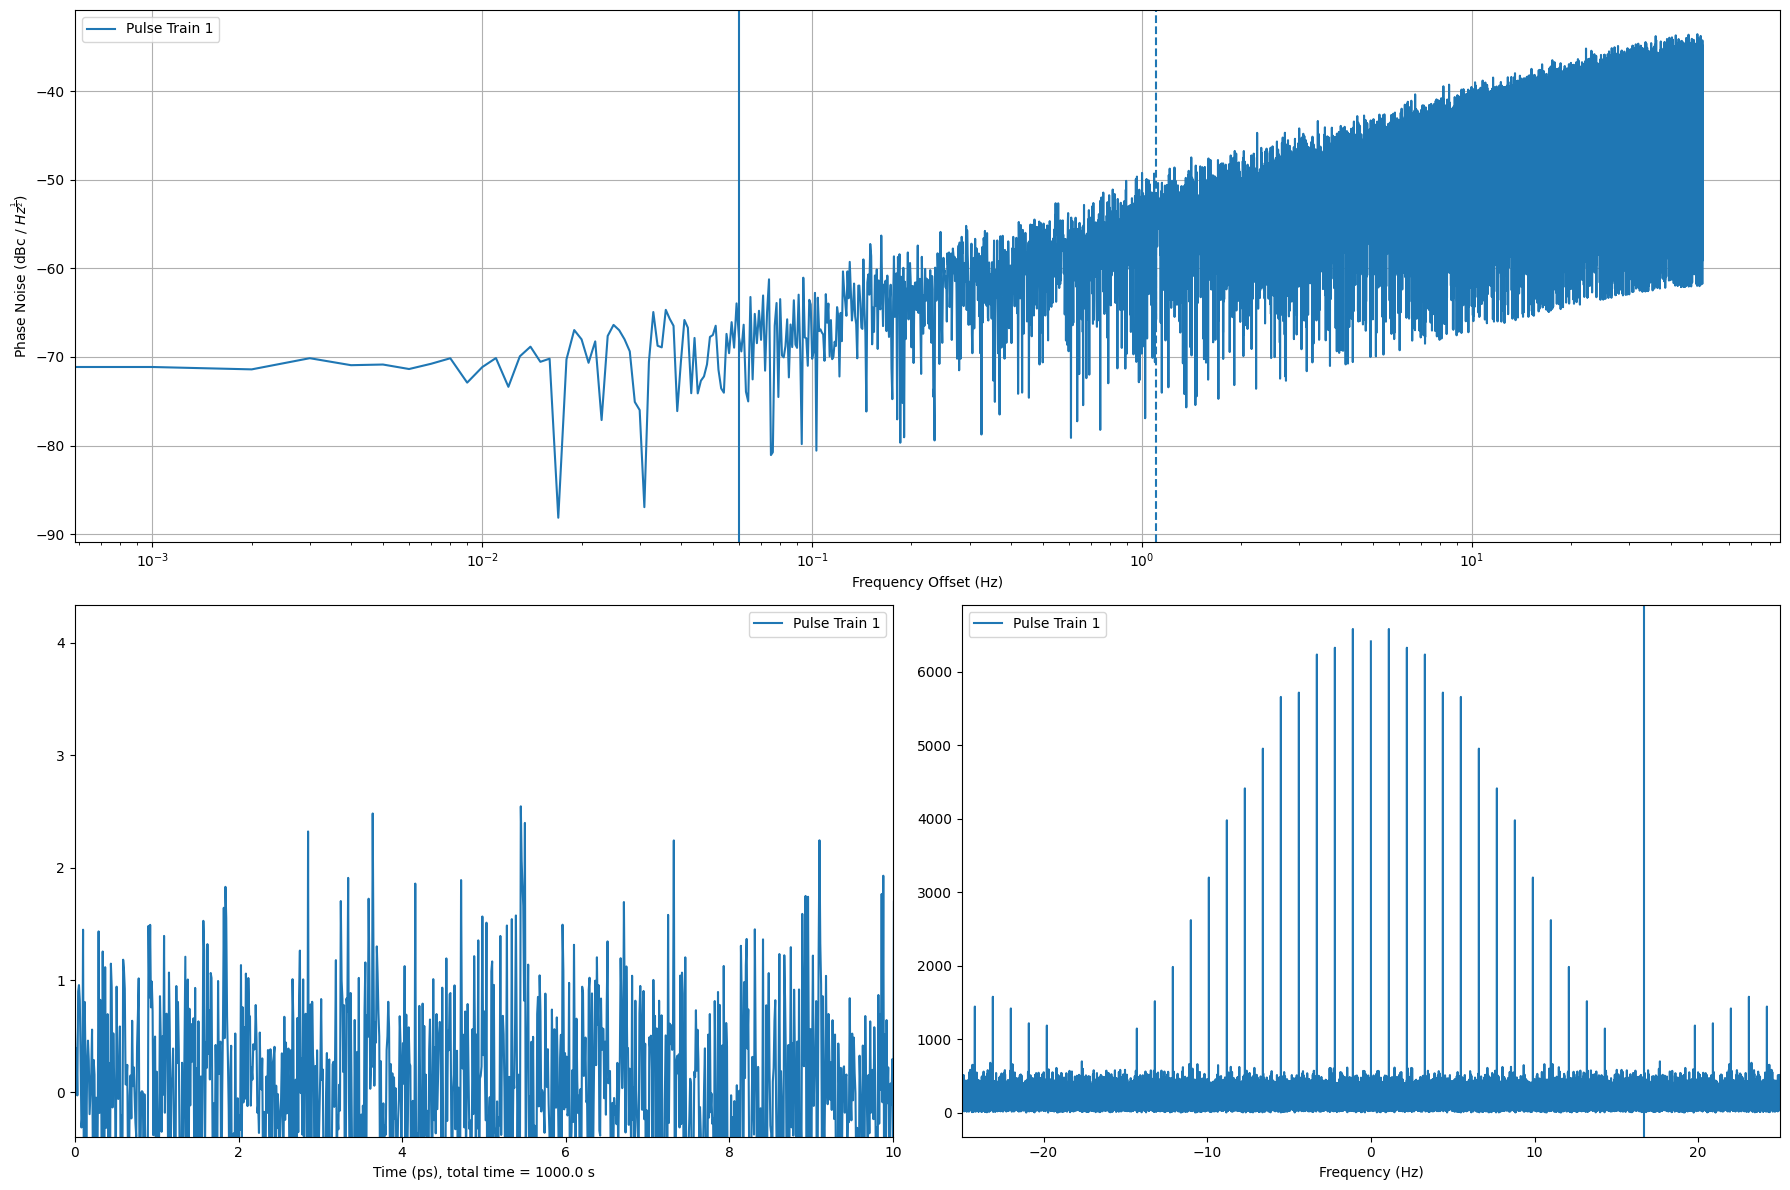

In [4]:
fig = plt.figure(figsize=(18,12),tight_layout=True)
axs = fig.subplot_mosaic([['T', 'T'],['BL', 'BR']],gridspec_kw={'width_ratios':[1, 1]})


for i, param in enumerate(params):
    num_samples = int(param['time'] * param['sample_rate'])
    t = np.linspace(0, param['time'], num_samples, endpoint=False)
    pulse_train = np.zeros_like(t)
    num_pulses = int(param['time'] * param['rep_rate'])
    pulse_samples = int(param['pulse_duration'] * param['sample_rate'])
    pulse_drift = np.linspace(0, param['drift']/param['rep_rate'], num_pulses)*np.exp(np.linspace(0, 100*param['drift'], num_pulses))
    pulse_times_noise = np.random.normal(loc=np.arange(num_pulses) / param['rep_rate'], scale=param['jitter'] / param['rep_rate'], size=num_pulses)
    pulse_times = np.add(pulse_times_noise, pulse_drift)
    
    # GENERATE COMB: PULSE TRAIN & SPECTRUM ####################################
    for pulse_time in pulse_times:
        start_index = int(pulse_time * param['sample_rate'])
        if start_index + pulse_samples < num_samples:
            pulse_train[start_index:start_index + pulse_samples] = 1

    pulse_train += param['noise'] * np.random.normal(size=num_samples)

    frequencies = np.fft.fftfreq(n=num_samples, d=1/param['sample_rate'])
    spectrum = np.fft.fft(pulse_train)

    # TRANSFER FUNCTION ########################################################
    L = 100e-3  # Path length in meters
    c = 3e8   # Speed of light in vacuum, meters per second
    n_0 = param['n_0'] #refractive index
    alpha_0 = param['alpha_0'] #apbsorption coefficient
    nt = n_0 + 0.1*  np.sin(frequencies*2*np.pi) 
    alpha = alpha_0 * np.exp(-frequencies / 1.5e14) 
    H_absorption = np.exp(-alpha * L)
    H_phase = np.exp(-1j * 2 * np.pi * frequencies * (nt - 1) * L / c)
    H = H_absorption * H_phase

    mod_spectrum = spectrum * H
    
    # PHASE NOISE #############################################################
    phase_angles = np.angle(mod_spectrum)
    phase_diff = np.diff(phase_angles)  # Difference between phases
    # phase_diff = np.diff(spectrum)
    # spec_diff = np.diff(spectrum)
    # phase_diff = np.angle(spec_diff)
    power_spec_dens = np.abs(np.fft.ifft(phase_diff))**1 # Power spectral density
    pnd = 10 * np.log10(power_spec_dens / param['sample_rate'])  # Convert to dBc/Hz

    combs.append({})
    combs[i]['frequencies'] = frequencies
    combs[i]['pnp'] = power_spec_dens
    combs[i]['mod_spectrum'] = mod_spectrum
    combs[i]['pulse_train'] = pulse_train

    if i == 0:
        comb1['frequencies'] = frequencies
        comb1['pnp'] = power_spec_dens
        comb1['mod_spectrum'] = mod_spectrum
        comb1['pulse_train'] = pulse_train
    elif i == 1:
        comb2['frequencies'] = frequencies
        comb2['pnp'] = power_spec_dens
        comb2['mod_spectrum'] = mod_spectrum
        comb2['pulse_train'] = pulse_train
    if i==0:
    # PLOT #####################################################################
        axs['T'].semilogx(frequencies[:num_samples//2], pnd[:num_samples//2], label=f'Pulse Train {i+1}')
    # axs['T'].semilogx(frequencies[:num_samples-1], pnd[:num_samples])
    # axs['T'].semilogx(frequencies[:num_samples-1], pnp[:num_samples])
    # axs['T'].semilogx(frequencies[:num_samples//2]/1e6, 10*np.log10(1/(frequencies[:num_samples//2]*1e-3)), 'r--')
        axs['T'].axvline(param['rep_rate'], linestyle='--')#, label=f'Rep Rate {i+1}')
        axs['T'].axvline(param['pulse_duration'])
        axs['T'].set_xlabel('Frequency Offset (Hz)')
        axs['T'].set_ylabel(r'Phase Noise (dBc / $Hz^{\frac{1}{2}}$)')
    # axs['T'].set_xlim(1e-0, 1e6)
    # axs['T'].set_ylim(-200, -0)
        axs['T'].grid(True)
        axs['T'].legend()

        axs['BL'].plot(t, pulse_train, label=f'Pulse Train {i+1}')
        axs['BL'].set_ylim(np.max(pulse_train) * np.array([-0.1, 1.1]))
        axs['BL'].set_xlabel(f'Time (ps), total time = {param['time']} s')
        axs['BL'].set_xlim(0, len(t)/10000)
        axs['BL'].legend()

        axs['BR'].plot(frequencies, np.abs(mod_spectrum), label=f'Pulse Train {i+1}')
        axs['BR'].axvline(16.666)
        axs['BR'].axvline(33.333)
        axs['BR'].set_xlabel('Frequency (Hz)')
        axs['BR'].set_xlim(-25, 25)
        axs['BR'].legend()

plt.tight_layout()
plt.show()


In [5]:
import jcamp as jc


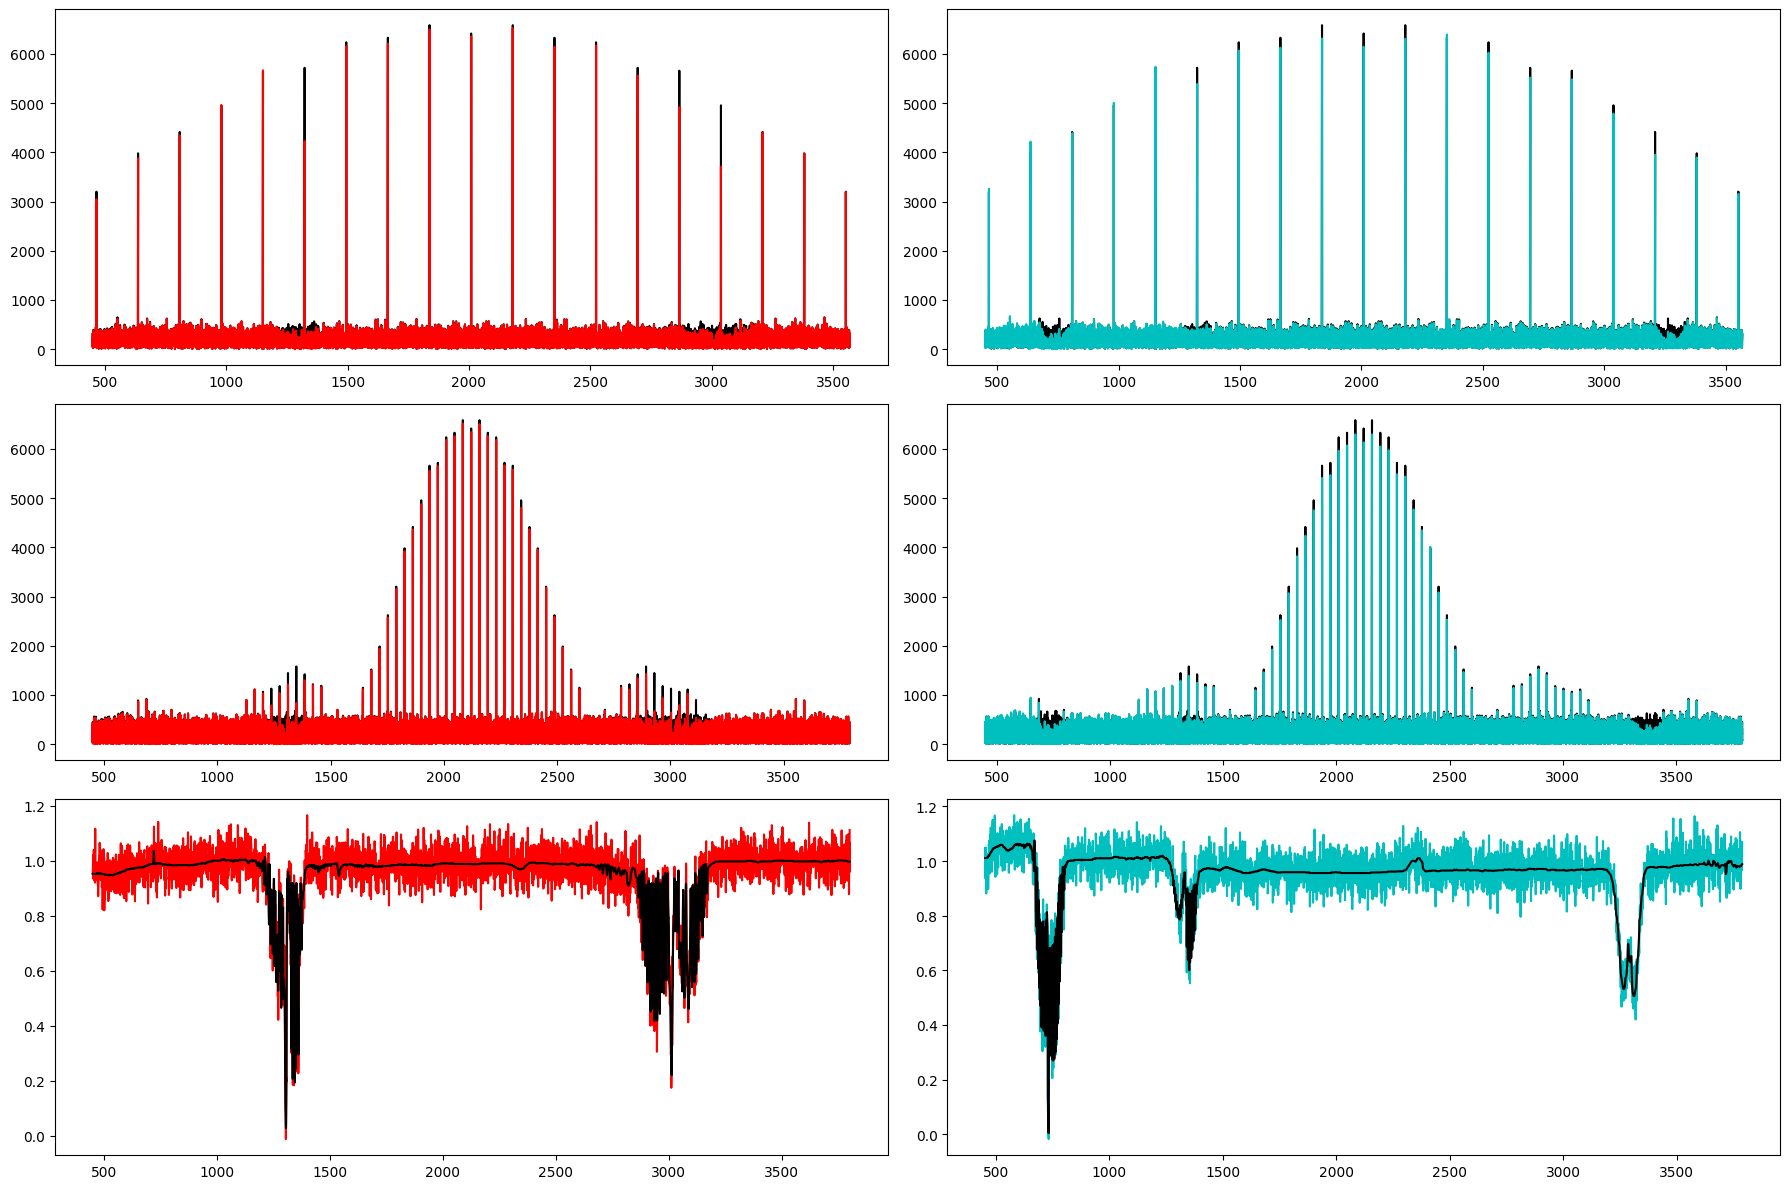

In [6]:
methaneIR = jc.jcamp_readfile('74-82-8-IR.jdx')
ethyneIR = jc.jcamp_readfile('74-86-2-IR.jdx')

data1X,data1Y = methaneIR['x'],methaneIR['y']
data2X,data2Y = ethyneIR['x'],ethyneIR['y']

#np.savetxt('spectrumCH4.csv', (methaneIR['x'],methaneIR['y']), delimiter=',')
#np.savetxt('spectrumC2H2.csv', (ethyneIR['x'],ethyneIR['y']), delimiter=',')

#plt.plot(data1X,data1Y)
#plt.plot(data2X,data2Y)

#orderedfreq=np.concatenate( (comb1['frequencies'][50001:100000],comb1['frequencies'][0:50000]),axis=0)
#orderedspectrum=np.concatenate( (comb1['mod_spectrum'][50001:100000],comb1['mod_spectrum'][0:50000]),axis=0)

#subfreq=orderedfreq[32085:67915]
#subspec=orderedspectrum[32085:67915]

def decimateAvg(L,newSize):
    '''decreasing resolution'''
    factor = int(L.size/newSize)
    newL=np.zeros(newSize,dtype=np.complex128)
    for i in range(newSize):
        count=0
        for j in range(factor):
            count+=L[i*factor+j]

        newL[i]=count/factor

    return(newL)

def decimateMax(L,newSize):
    '''decreasing resolution'''
    factor = int(L.size/newSize)
    newL=np.zeros(newSize,dtype=np.complex128)
    for i in range(newSize):
        count=0+0j
        for j in range(factor):
            if(np.abs(count)<np.abs(L[i*factor+j])):count=L[i*factor+j]

        newL[i]=count

    return(newL)

def dexiplyBlock(L, newSize):
    '''increasing resolution'''
    factor = int(np.ceil(newSize/L.size))
    newL=np.zeros(newSize,dtype=np.complex128)
    marker=0
    for i in range(newSize):
        newL[i]=L[marker]
        if int((marker+1)*factor<i):marker+=1
        
    return(newL)

def dexiplyLinear(L,newSize):
    '''increasing resolution (linear interpolation)'''
    factor =np.ceil(newSize/L.size)
    newL=np.zeros(newSize,dtype=np.complex128)
    marker=0
    for i in range(newSize):
        if factor*(marker+1)==i:
            newL[i]=L[marker]
            marker+=1
        elif marker+1<L.size:
            newL[i]=((marker+1.0)-(i+0.0)/(factor+0.0))*L[marker]+(0.0-marker+(i+0.0)/(factor+0.0))*L[marker+1]
        else:newL[i]=L[-1]
    return(newL)


def randIR(spec,noise):
    '''adding noise to IR spectrum'''
    return(spec+np.random.normal(0,noise,spec.size))


#orderedspectrum=np.concatenate( (comb1['mod_spectrum'][17501:35000],comb1['mod_spectrum'][0:17501]),axis=0)
#data1YPrime=dexiplyLinear(data1Y,27000)
#data1YPrime2=dexiplyBlock(data1Y,35000)
'''
data1XPrime=dexiplyLinear(data1X,27000)
combPrime=decimateAvg(orderedspectrum,3500)
data11Y=data1Y*combPrime
data22Y=data2Y*combPrime
'''

orderComb1 = np.concatenate( (combs[0]['mod_spectrum'][int(combs[0]['mod_spectrum'].size/2)+1:combs[0]['mod_spectrum'].size], combs[0]['mod_spectrum'][0:int(combs[0]['mod_spectrum'].size/2)]), axis=0)
orderComb=[]
noisyCH4_IR=[]
combsCH4 =[]
combsC2H2 = []
noisyC2H2_IR=[]

#this code takes the spectra and reorders them, it also adds the "noise" to the IR
for k in range(numberOfCombs):
    orderComb.append(np.concatenate( (combs[k]['mod_spectrum'][int(combs[k]['mod_spectrum'].size/2)+1:combs[k]['mod_spectrum'].size], combs[k]['mod_spectrum'][0:int(combs[k]['mod_spectrum'].size/2)]), axis=0))
    if(k%2==0): 
        noisyCH4_IR.append(randIR(methaneIR['y'],0.05))
        #combsCH4.append(dexiplyLinear(data1Y, orderComb[k][40000:60000].size)*orderComb[k][40000:60000])
    else:
        noisyC2H2_IR.append(randIR(ethyneIR['y'],0.05))


modComb1 = dexiplyLinear(data1Y, orderComb1[40000:60000].size)*orderComb1[40000:60000]  #passing the methane IR through the 0th comb in the -10 to 10 range
modAxis1 = dexiplyLinear(data1X, orderComb1[40000:60000].size)
modComb2 = dexiplyLinear(data2Y, orderComb1[40000:60000].size)*orderComb1[40000:60000]  #passing the ethyne IR through the 0th comb in the -10 to 10 range
modComb1full = dexiplyLinear(data1Y, orderComb1.size)*orderComb1                        #passing the methane IR through the 0th comb in the full range
modAxis1full = dexiplyLinear(data1X, orderComb1.size)
modComb2full = dexiplyLinear(data2Y, orderComb1.size)*orderComb1                        #passing the ethyne IR through the 0th comb in the -full range


fig = plt.figure(figsize=(18,12),tight_layout=True)
axs = fig.subplot_mosaic([['TL','TR'],['BL','BR'],['BBL','BBR']],gridspec_kw={'width_ratios':[1, 1]})

axs['TL'].plot(np.abs(modAxis1),np.abs(orderComb1[40000:60000]),c='k')
axs['TL'].plot(np.abs(modAxis1),np.abs(modComb1), c='r')
axs['TR'].plot(np.abs(modAxis1),np.abs(orderComb1[40000:60000]),c='k')
axs['TR'].plot(np.abs(modAxis1),np.abs(modComb2), c='c')

axs['BL'].plot(np.abs(modAxis1full),np.abs(orderComb1),c='k')
axs['BL'].plot(np.abs(modAxis1full),np.abs(modComb1full), c='r')
axs['BR'].plot(np.abs(modAxis1full),np.abs(orderComb1),c='k')
axs['BR'].plot(np.abs(modAxis1full),np.abs(modComb2full), c='c')

axs['BBL'].plot(data1X,noisyCH4_IR[50],c='r')
axs['BBL'].plot(data1X,data1Y,c='k')

axs['BBR'].plot(data2X,noisyC2H2_IR[50],c='c')
axs['BBR'].plot(data2X,data2Y,c='k')

#plt.plot(data1X, np.abs(combPrime), color='green')
#plt.plot(data1X, np.abs(data11Y))
#plt.plot(data1X, np.abs(data22Y))
#plt.plot(data1XPrime,data1YPrime)
#plt.plot(data1XPrime,data1YPrime2)



# Heterodyning

/var/folders/tl/2hjtn9nn2cv6j4rb1nygnp9c0000gn/T/ipykernel_49396/475629161.py:13: RuntimeWarning: invalid value encountered in sqrt
  phase_noise_dbc_hz = 10 * np.log10(np.array(phase_noise_power)/np.sqrt(np.array(frequencies[1:])) )


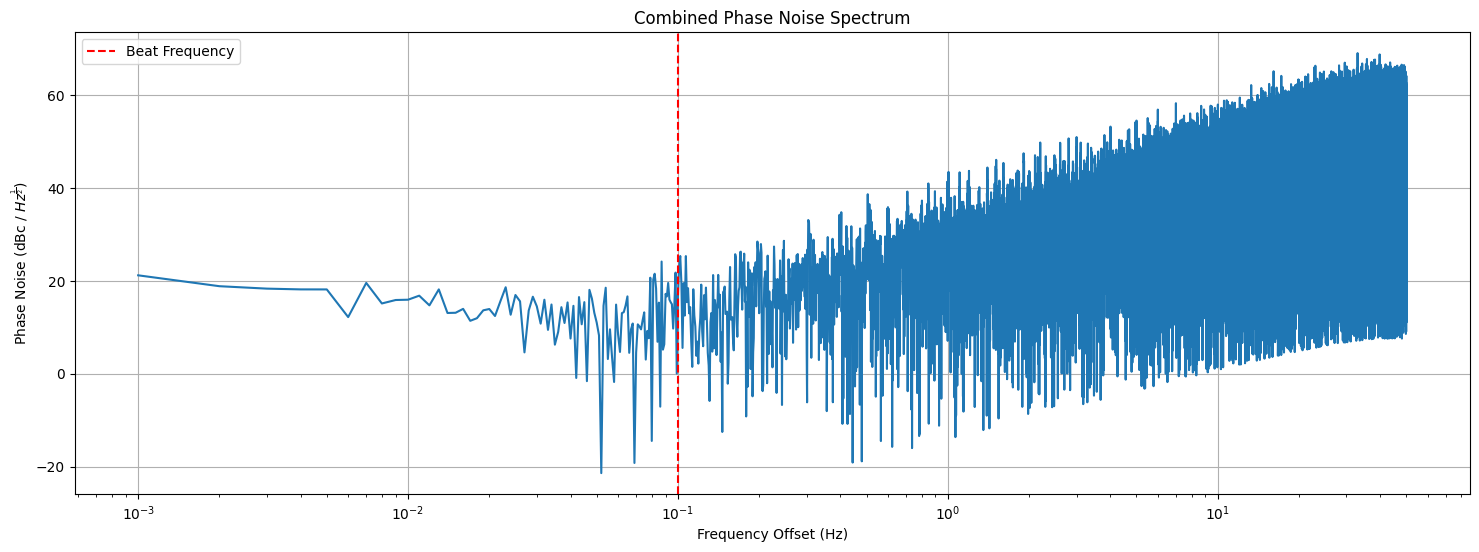

In [5]:
num = int(params[0]['time'] * params[0]['sample_rate'])
pulse_trains = [comb1['pulse_train'], comb2['pulse_train']]
combined_pulse_train = np.sum([pulse_trains[1]+ pulse_trains[0]], axis=0)
# combined_pulse_train = np.subtract(pulse_trains[1], pulse_trains[0])

fft_result = np.fft.fft(combined_pulse_train)
frequencies = np.fft.fftfreq(num, 1/params[0]['sample_rate'])

phase_angles = np.angle(fft_result)
phase_diff = np.diff(phase_angles) 
# phase_diff = np.diff(fft_result) 
phase_noise_power = np.abs(np.fft.fft(phase_diff))**2
phase_noise_dbc_hz = 10 * np.log10(np.array(phase_noise_power)/np.sqrt(np.array(frequencies[1:])) )

beat = np.abs(params[0]['rep_rate'] - params[1]['rep_rate'])

plt.figure(figsize=(18, 6))
plt.semilogx(frequencies[1:], phase_noise_dbc_hz)
# plt.semilogx(frequencies[:num//2-1], (phase_noise_power/params[0]['sample_rate'])[:num//2-1])
plt.axvline(beat, color='r', linestyle='--', label='Beat Frequency')
plt.title('Combined Phase Noise Spectrum')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Frequency Offset (Hz)')
plt.ylabel(r'Phase Noise (dBc / $Hz^{\frac{1}{2}}$)')
plt.grid(True)
plt.legend()
plt.show()